팀원들의 알파를 combine

In [1]:
import sys

from pathlib import Path

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import seaborn as sns

In [10]:
# 경로설정

CWD = Path.cwd()
WORKSPACE_PATH = CWD.parent
COMMON_PATH = WORKSPACE_PATH / 'common'
DATA_PATH = WORKSPACE_PATH / 'data'
ALPHAS_PATH = WORKSPACE_PATH / 'alphas'
FONT_PATH = COMMON_PATH / 'fonts' / 'NanumGothic.ttf'

JAEPIL_PATH = WORKSPACE_PATH / 'jaepil'
BOBAE_PATH = WORKSPACE_PATH / 'bobae'
GARAM_PATH = WORKSPACE_PATH / 'garam'

In [3]:
font_prop = font_manager.FontProperties(fname=FONT_PATH)
rc('font', family=font_prop.get_name())

In [4]:
sys.path.append(str(COMMON_PATH))

In [5]:
import fn_loader as fn
import fn_config as fncfg
import gaps_config as gcfg

from validator import *
from backtest import Backtest

기준이 되는 return

In [19]:
# loader 생성 (데이터 로드 + multi index로 전처리)
# use_alias=True 일 경우 긴 ETF명 대신 축약한 단어 사용
pricevolume1 = fn.FnDataLoader('DBGAPS2024_pricevolume_240722.xlsx', use_alias=True)  

In [20]:
pricevolume1.get_datafields()

Index(['return', 'adjopen', 'adjhigh', 'adjlow', 'adjclose', 'moneyvolume'], dtype='object')

In [21]:
return_df = pricevolume1.get_data('return') / 100 # 
return_df.head() 

,shortterm,usd,usdinv,kodexinv,oil,gold,hybond,midbond,10y,csi300,nikkei,euro50,sp500,kosdaq150,kodex200
Date,,,,,,,,,,,,,,,
2016-03-04,0.0000,-0.0096,0.0092,-0.0012,0.0127,0.0183,0.0037,-0.0020,-0.0019,0.0042,0.0019,-0.0046,0.0043,0.0028,0.0002
2016-03-07,0.0000,-0.0036,0.0019,-0.0024,0.0458,-0.0021,0.0037,0.0017,0.0000,0.0048,-0.0024,-0.0005,0.0006,-0.0051,0.0021
2016-03-08,-0.0001,0.0045,-0.0043,0.0079,0.0093,0.0067,0.0005,0.0000,0.0029,-0.0089,-0.0048,-0.0005,-0.0011,0.0009,-0.0070
2016-03-09,0.0002,0.0097,-0.0082,-0.0042,-0.0145,-0.0107,-0.0005,-0.0014,-0.0005,-0.0035,-0.0100,-0.0057,-0.0021,0.0060,0.0043
2016-03-10,-0.0001,-0.0108,0.0112,-0.0073,0.0174,-0.0046,-0.0010,0.0019,-0.0010,0.0021,0.0116,0.0010,0.0017,0.0055,0.0092


팀원들 weights

In [23]:
jp_mvo = pd.read_pickle(ALPHAS_PATH / 'jaepil_mvo.pkl')

In [47]:
asset_order = jp_mvo.columns
asset_order

Index(['kodex200', 'kosdaq150', 'sp500', 'euro50', 'nikkei', 'csi300', '10y',
       'midbond', 'hybond', 'gold', 'oil', 'kodexinv', 'usd', 'usdinv',
       'shortterm'],
      dtype='object')

In [33]:
bb_rp = pd.read_excel(BOBAE_PATH / '포트폴리오비중_20240722.xlsx', index_col=0)

In [35]:
bb_rp.index = pd.to_datetime(bb_rp.index)
bb_rp.drop('cash', axis=1, inplace=True) # cash 대신 mmf 쓸꺼니까 삭제. 

# 하지만 cash의 weight는 1%~50% 사이이다. 즉, weight sum이 1이 아닌 0.99가 되어야 함. 

In [49]:
bb_rp = bb_rp[asset_order].copy() # column 순서를 맞춰준다. 필수적. 

In [53]:
bb_rp.head()

,kodex200,kosdaq150,sp500,euro50,nikkei,csi300,10y,midbond,hybond,gold,oil,kodexinv,usd,usdinv,shortterm
2017-03-31,0.075739,0.024261,0.061996,0.024536,0.105793,1.843618e-16,0.091880,0.246915,0.070684,0.049744,0.037806,1.048559e-16,4.206704e-17,0.081408,0.129236
2017-04-28,0.074142,0.025858,0.067842,0.028076,0.109789,1.995288e-16,0.094179,0.256790,0.088831,0.056830,0.053139,0.000000e+00,0.000000e+00,0.099928,0.044597
2017-05-31,0.073757,0.026243,0.076124,0.032768,0.111799,1.512275e-16,0.093742,0.246853,0.095403,0.067908,0.056714,0.000000e+00,0.000000e+00,0.108690,0.010000
2017-06-30,0.079063,0.020937,0.072915,0.026224,0.078658,4.974382e-17,0.073626,0.216797,0.097338,0.081857,0.025074,0.000000e+00,1.159833e-01,0.000000,0.111527
2017-07-31,0.078399,0.021601,0.098882,0.030777,0.109481,7.554179e-17,0.087100,0.230072,0.125801,0.092067,0.019168,5.967178e-17,9.018667e-02,0.000000,0.016466


In [55]:
bb_rp = ConstraintHandler.apply_constraints(
    weights_df=bb_rp,
    objective_function=obj_mse
).copy() # 최대한 본래 weight를 안건드리며 weight를 재조정한다. 

bb_rp.head() # 위의 weight와 비교해보자. 거의 안바뀐 것을 확인할 수 있음. 

,kodex200,kosdaq150,sp500,euro50,nikkei,csi300,10y,midbond,hybond,gold,oil,kodexinv,usd,usdinv,shortterm
2017-03-31,0.075717,0.024283,0.061044,0.023540,0.104801,0.000000e+00,0.090901,0.245793,0.069702,0.048743,0.036815,5.963112e-19,1.761829e-19,8.043854e-02,0.128222
2017-04-28,0.074117,0.025883,0.066874,0.027079,0.108777,0.000000e+00,0.093184,0.255656,0.087842,0.055854,0.052167,0.000000e+00,4.099639e-19,9.892669e-02,0.043641
2017-05-31,0.073721,0.026279,0.075179,0.031991,0.110799,2.303930e-19,0.092770,0.245646,0.094428,0.066988,0.055811,0.000000e+00,3.388132e-20,1.076950e-01,0.008694
2017-06-30,0.079035,0.020965,0.071968,0.025234,0.077702,4.065758e-20,0.072678,0.215611,0.096351,0.080895,0.024079,6.098637e-19,1.149649e-01,1.355253e-20,0.110516
2017-07-31,0.078359,0.021641,0.097913,0.029862,0.108495,0.000000e+00,0.086151,0.228877,0.124786,0.091110,0.018244,3.252607e-19,8.923308e-02,0.000000e+00,0.015330


Alpha 화

생성과 동시에 constraint 만족 검증까지 함. 

In [31]:
jp_mvo_alpha = Alpha('jaepil', jp_mvo)

In [56]:
bb_rp_alpha = Alpha('bobae', bb_rp)

Backtest 화 

In [58]:
jp_mvo_back = Backtest(jp_mvo_alpha, return_df)

In [59]:
bb_rp_back = Backtest(bb_rp_alpha, return_df)

두 백테 + 가람 결과를 plot 

가람이꺼는 cum return series만 가져옴

In [61]:
import pickle

with open(ALPHAS_PATH / 'garam_hrp_cumreturn.pkl', 'rb') as f:
    gr_hrp_cumreturn = pickle.load(f)

<Axes: xlabel='Date'>

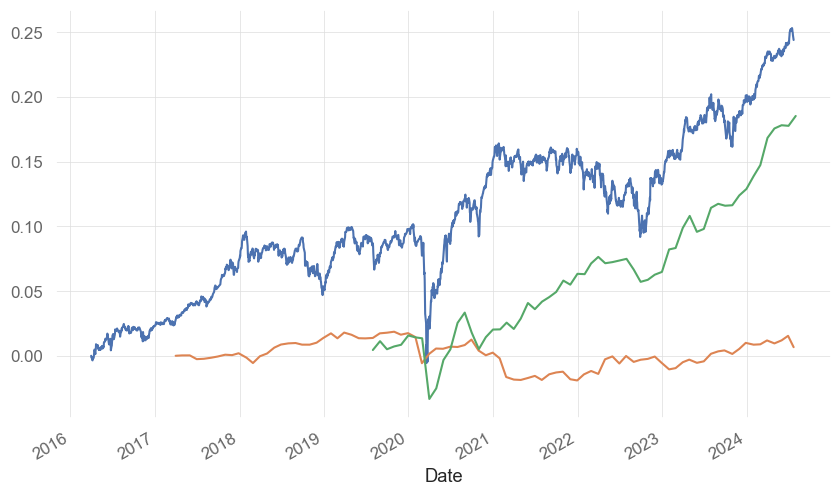

In [64]:
# 지금 시작시점이 다 달라서 제대로 비교 불가. 
# 앞으로 같은 데이터셋 사용해야 이런 문제 최소화 가능. 

jp_mvo_back.plot_cum_return()
bb_rp_back.plot_cum_return()
(gr_hrp_cumreturn - 1).plot()
